In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
os.path.join('MiniProjectDataset','train.csv', 'train.csv')

'MiniProjectDataset\\train.csv\\train.csv'

In [3]:
df = pd.read_csv(os.path.join('MiniProjectDataset','train.csv', 'train.csv'))

In [4]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [5]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [6]:
X = df['comment_text']
y = df[df.columns[2:]].values

print(X)

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object


In [7]:
MAX_FEATURES = 200000 # number of words in the vocab

In [8]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [9]:
vectorizer.adapt(X.values)
X.values

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

In [10]:
vectorized_text = vectorizer(X.values)
# vectorized_text

In [11]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [12]:
batch_X,batch_Y = dataset.as_numpy_iterator().next()

In [13]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [14]:
train_generator = train.as_numpy_iterator()

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [16]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [17]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          6400032   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 6,491,686
Trainable params: 6,491,686
Non-trainable params: 0
______________________________________________

In [20]:
history = model.fit(train, epochs=3, validation_data=val)

Epoch 1/3
6981/6981 [==============================] - 9292s 1s/step - loss: 0.0611 - val_loss: 0.0476
Epoch 2/3
6981/6981 [==============================] - 9459s 1s/step - loss: 0.0453 - val_loss: 0.0414
Epoch 3/3
6981/6981 [==============================] - 13610s 2s/step - loss: 0.0405 - val_loss: 0.0376


In [21]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

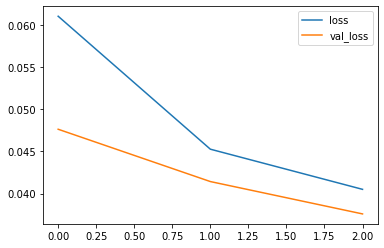

In [22]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [19]:
input_text = vectorizer(['You freaking suck! I am going to hit you.'])

In [20]:
input_text

<tf.Tensor: shape=(1, 1800), dtype=int64, numpy=array([[   7, 7113,  396, ...,    0,    0,    0]], dtype=int64)>

In [21]:
res = model.predict(input_text)

In [22]:
res

array([[0.49959353, 0.49970296, 0.49744016, 0.5010703 , 0.50245047,
        0.50133616]], dtype=float32)

In [23]:
(res > 0.5).astype(int)

array([[0, 0, 0, 1, 1, 1]])

In [24]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [25]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 1, 1],
       [0, 1, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 1, 1],
       [1, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 1, 1],
       [1, 1, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [1, 1, 0, 1, 1, 1],
       [0, 1, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 1, 1]])

In [27]:
res.shape

NameError: name 'res' is not defined

In [28]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [26]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

NameError: name 'Precision' is not defined

In [30]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

KeyboardInterrupt: 

In [34]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8662614226341248, Recall:0.7428323030471802, Accuracy:0.5115346312522888


In [60]:
pip install --upgrade pip --user

  Using cached pip-22.2.2-py3-none-any.whl (2.0 MB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [56]:
!pip install gradio jinja2

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

starlette 0.19.1 requires typing-extensions>=3.10.0; python_version < "3.10", but you'll have typing-extensions 3.7.4.3 which is incompatible.



  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4714 sha256=e35dbbf6ae7f8722461437ee153b16caae2afda72893296969c13cc720e3db7d
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\ff\5b\59\913b443e7369dc04b61f607a746b6f7d83fb65e2e19fcc958d
  Created wheel for python-multipart: filename=python_multipart-0.0.5-py3-none-any.whl size=31675 sha256=20387a0223b7c16a30a93372079647d949b785627f7bce8d1bc086ff60017bc2
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\9e\fc\1c\cf980e6413d3ee8e70cd8f39e2366b0f487e3e221aeb452eb0
Successfully built ffmpy python-multipart


In [71]:
pip install gradio --user

Note: you may need to restart the kernel to use updated packages.


In [72]:
pip list

Package                            Version
---------------------------------- -------------------
absl-py                            0.12.0
aiohttp                            3.8.1
aiosignal                          1.2.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
analytics-python                   1.4.0
anyio                              3.6.1
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.4.2
astropy                            4.0.2
astunparse                         1.6.3
async-generator                    1.10
async-timeout                      4.0.2
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.4
Babel                              2.8.1
backcall                           0


contextlib2                        0.6.0.post1
cryptography                       3.1.1
cycler                             0.10.0
cymem                              2.0.6
Cython                             0.29.21
cytoolz                            0.11.0
dask                               2.30.0
decorator                          4.4.2
defusedxml                         0.6.0
diff-match-patch                   20200713
distributed                        2.30.1
docutils                           0.16
entrypoints                        0.3
et-xmlfile                         1.0.1
evaluation                         0.0.2
fastapi                            0.80.0
fastcache                          1.1.0
ffmpy                              0.3.0
filelock                           3.0.12
flake8                             3.8.4
Flask                              1.1.2
flatbuffers                        1.12
folium                             0.12.1
frozenlist                         1.3.1
f

xlwt                               1.3.0
xmltodict                          0.12.0
yapf                               0.30.0
yarl                               1.8.1
zict                               2.0.0
zipp                               3.4.0
zope.event                         4.5.0
zope.interface                     5.1.2


In [27]:
import tensorflow as tf
import gradio as gr

In [28]:
import gradio.components as components

In [37]:
model.save('final_model.h5')

In [29]:
model = tf.keras.models.load_model('final_model.h5')

In [30]:
input_str = vectorizer(['hey i freaken hate you!'])

In [31]:
res = model.predict(np.expand_dims(input_str[0],0))

In [32]:
res

array([[0.73102766, 0.01160318, 0.11919346, 0.03377652, 0.3042255 ,
        0.10358027]], dtype=float32)

In [33]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [38]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

C:\ProgramData\Anaconda3\lib\site-packages\gradio\inputs.py:26: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\ProgramData\Anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\ProgramData\Anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [39]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7861/
Running on public URL: https://39524.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x24e65404850>,
 'http://127.0.0.1:7861/',
 'https://39524.gradio.app')

In [89]:
pip install gradio

'3.1.7'